# Telco Customer Churn Analysis

We have a classification problem. We wil make classification on the target variable Churn and we will build a model to get best classification possible on the target variable. We will look at the balance of the target variable. As we will see later, our target variable has imblanced data For that reason we are not going to use Accuracy score, Based on the problem on the hand, we will use Recall score. In order to combat class imbalance we can consider under/oversampling or drawing test data with equal proportions of classes.

## Data Dictionary

- CustomerID: A unique ID that identifies each customer.
- Gender: The customer’s gender: Male, Female
- Age: The customer’s current age, in years, at the time the fiscal quarter ended.
- Senior Citizen: Indicates if the customer is 65 or older: Yes, No
- Married (Partner): Indicates if the customer is married: Yes, No
- Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
- Number of Dependents: Indicates the number of dependents that live with the customer.
- Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
- Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
- Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
- Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
- Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
- Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
- Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
- Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
- Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
- Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
- Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
- Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
- Tenure: Indicates the total amount of months that the customer has been with the company.
- Churn: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Data Source - https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# Exploratory Data Analysis
Importing necessary libraries

In [512]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

Data import and first glimpse

In [513]:
df=pd.read_csv(r'C:\Users\xtaym\Desktop\VSC projects\datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [514]:
print(df.isna().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [515]:
print(df.duplicated().sum())

0


In [516]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Our data is complete. No records are duplicated nor missing. We will modify few columns:
- customerID - dropped because it has no influence on churn
- TotalCharges - changing datatype from object to float
- Churn - We will encode churn to 0/1 values

In [517]:
df=df.drop(columns='customerID',axis=1)
# we encountered a problem when converting Charges to float type, there were empty values. We converted them to Nan's and then converted column to float
df['TotalCharges']=df['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
print(df['TotalCharges'].isna().sum(), 'number of NAs')
# we will drop them because their number is irrelevant
df=df.dropna()
print(df['TotalCharges'].isna().sum(), 'number of NAs post deletion')

11 number of NAs
0 number of NAs post deletion


There is a imbalance across classes it will be taken into account when sampling data for model developement.

## Target Variable

Churn
No     5163
Yes    1869
Name: count, dtype: int64 
 Percentage of clients that churned: 0.27 
 Percentage of clients that stayed with the company: 0.73


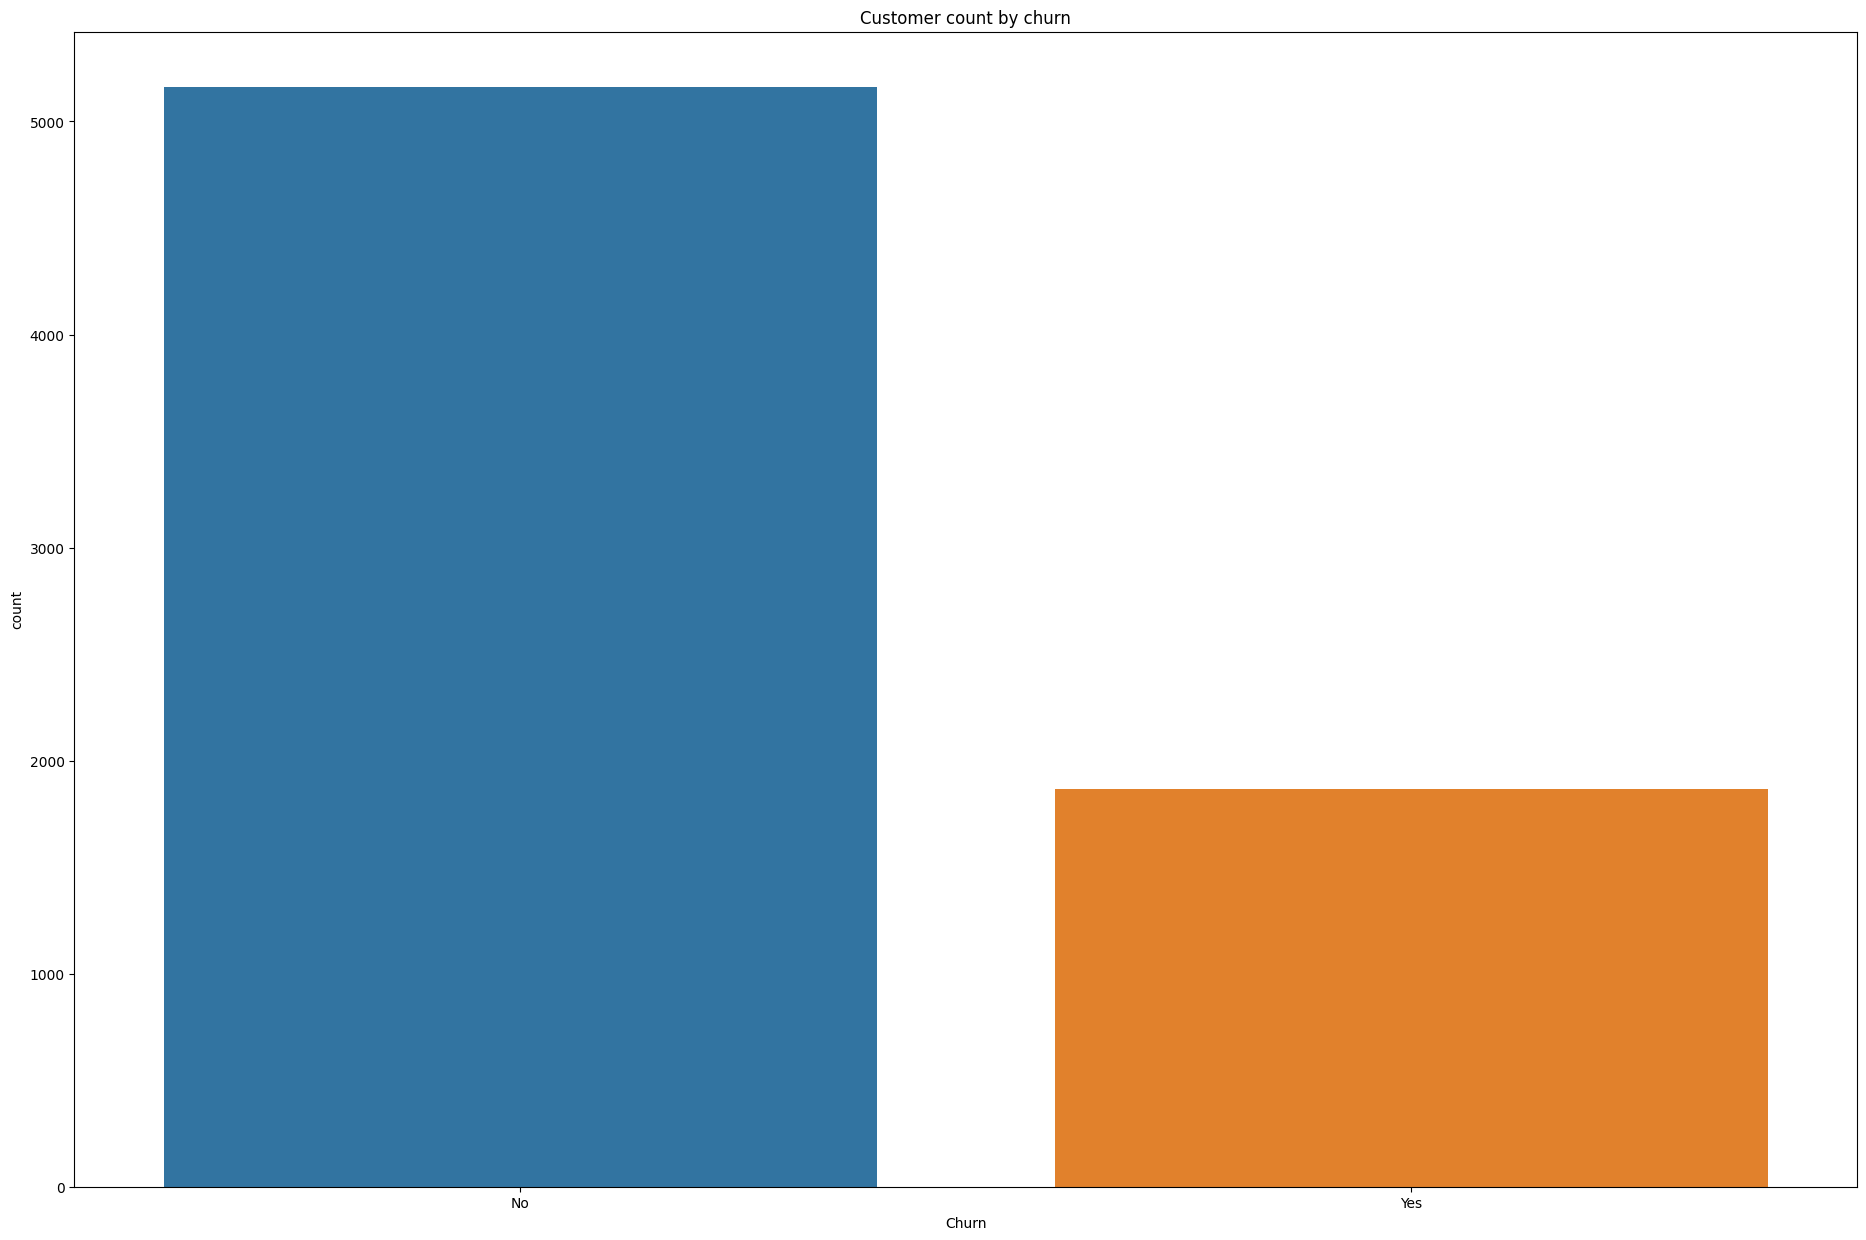

In [518]:
sns.countplot(df,x='Churn').set(title='Customer count by churn')
print(df['Churn'].value_counts(),'\n',
      'Percentage of clients that churned:' , round(df['Churn'][df['Churn']=='Yes'].value_counts()[0]/len(df),2),'\n',
      'Percentage of clients that stayed with the company:', round((1-(df['Churn'][df['Churn']=='Yes'].value_counts()[0])/len(df)),2))

We have imbalanced data. About 27% of the customers churned. Almost 73% of the customers stayed with the company.
1869 customer churned while 5174 customer did not.

In [519]:
le = LabelEncoder()
df['Churn']=le.fit_transform(df['Churn'])
#df['SeniorCitizen'] = df['SeniorCitizen'].astype(bool)
num_cols= df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns

print(
f'Numerical Columns:  {df[num_cols].columns}','\n','\n',
f'Categorical Columns: {df[cat_cols].columns}')

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object') 
 
 Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [520]:
df[num_cols].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


Text(0.5, 0.98, 'Histograms of numerical variables')

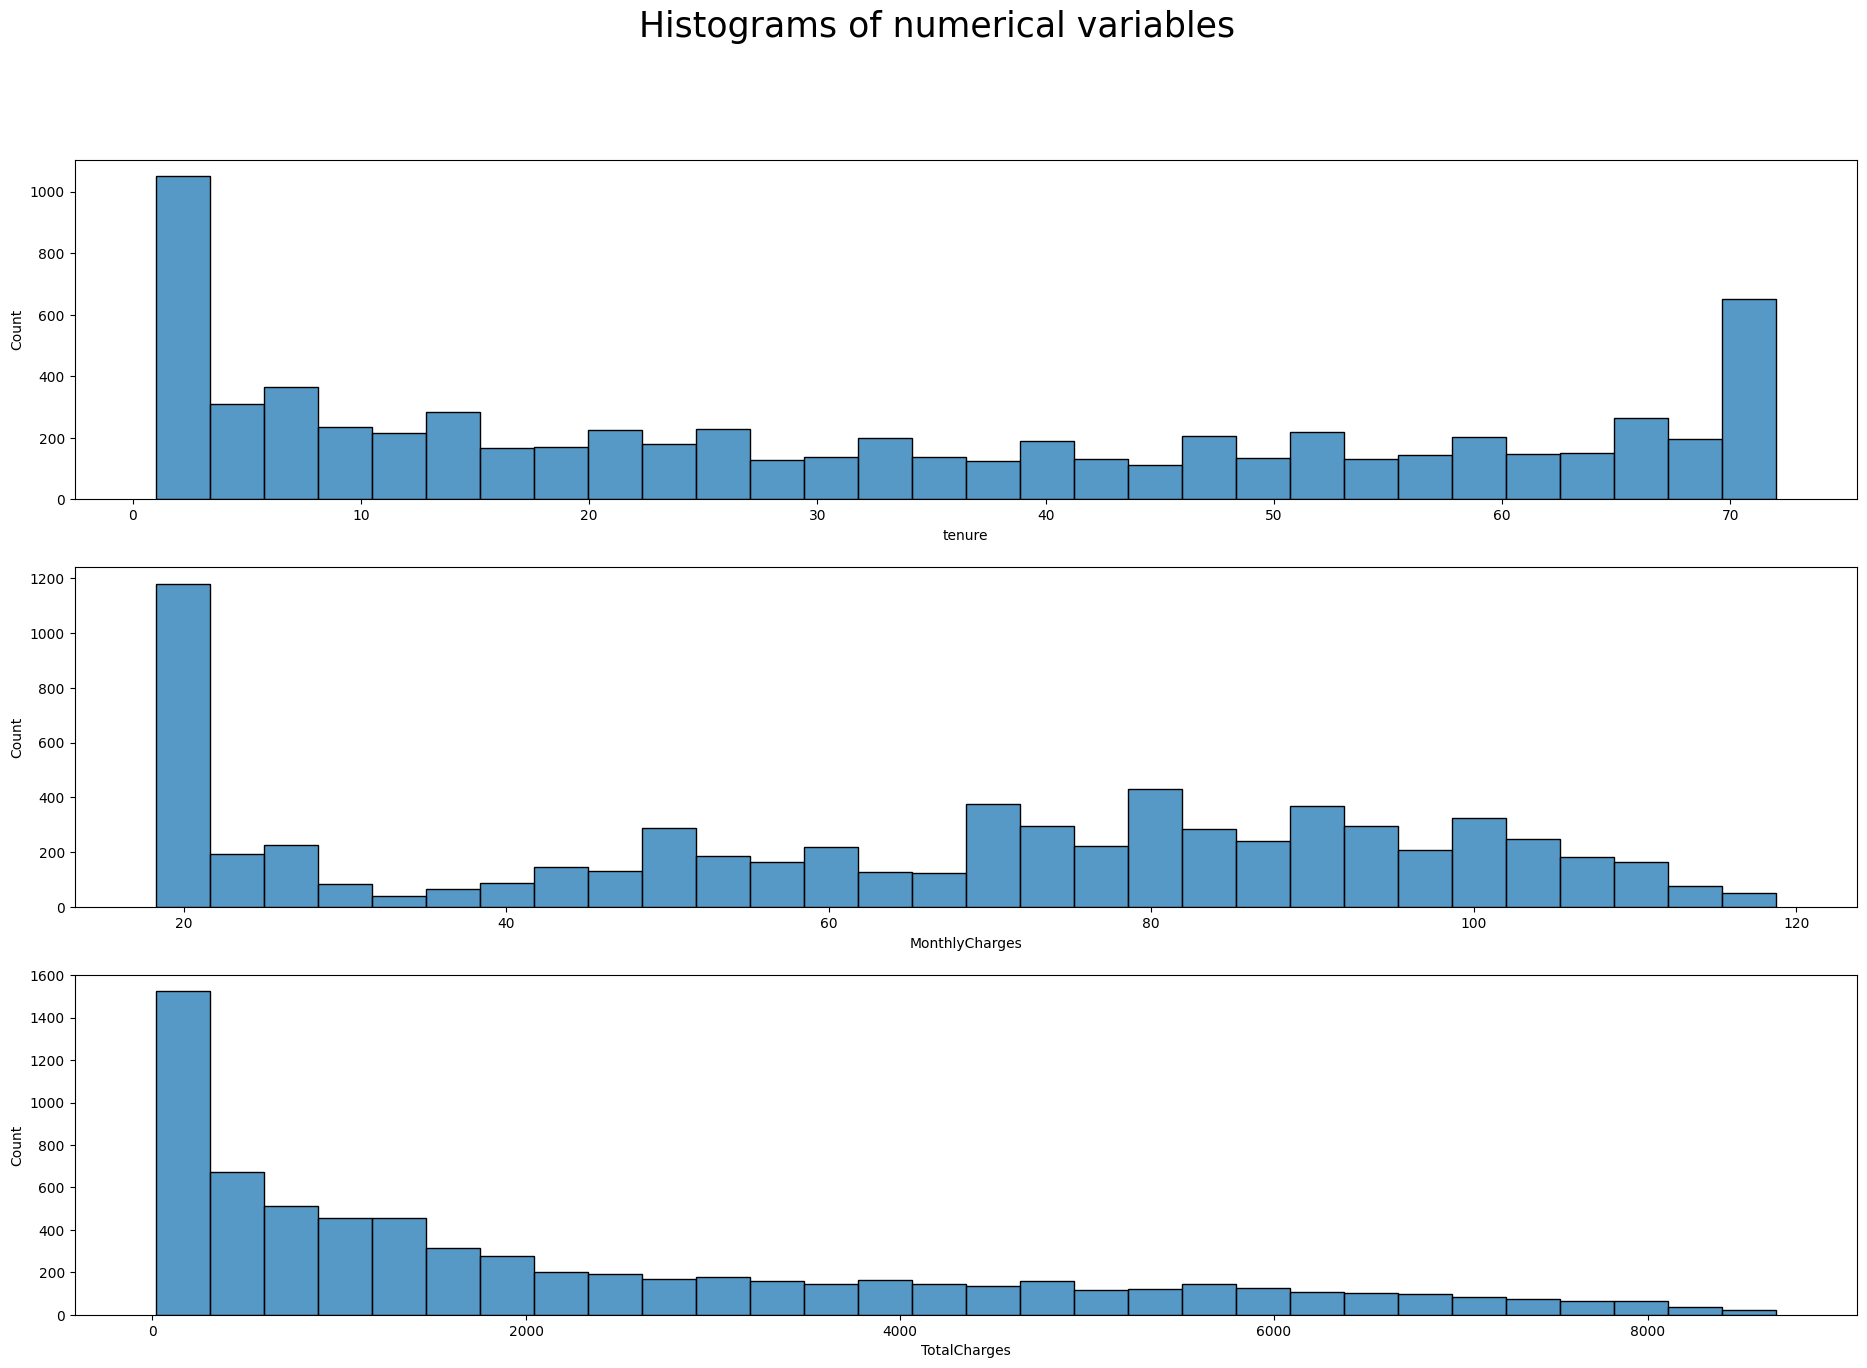

In [521]:
fig, ax =plt.subplots(3,1)
plt.rcParams["figure.figsize"] = [23, 15]
sns.histplot(data=df,x='tenure',bins=30,ax=ax[0])
sns.histplot(data=df,x='MonthlyCharges',bins=30,ax=ax[1])
sns.histplot(data=df,x='TotalCharges',bins=30,ax=ax[2])
fig.suptitle('Histograms of numerical variables',size=25)

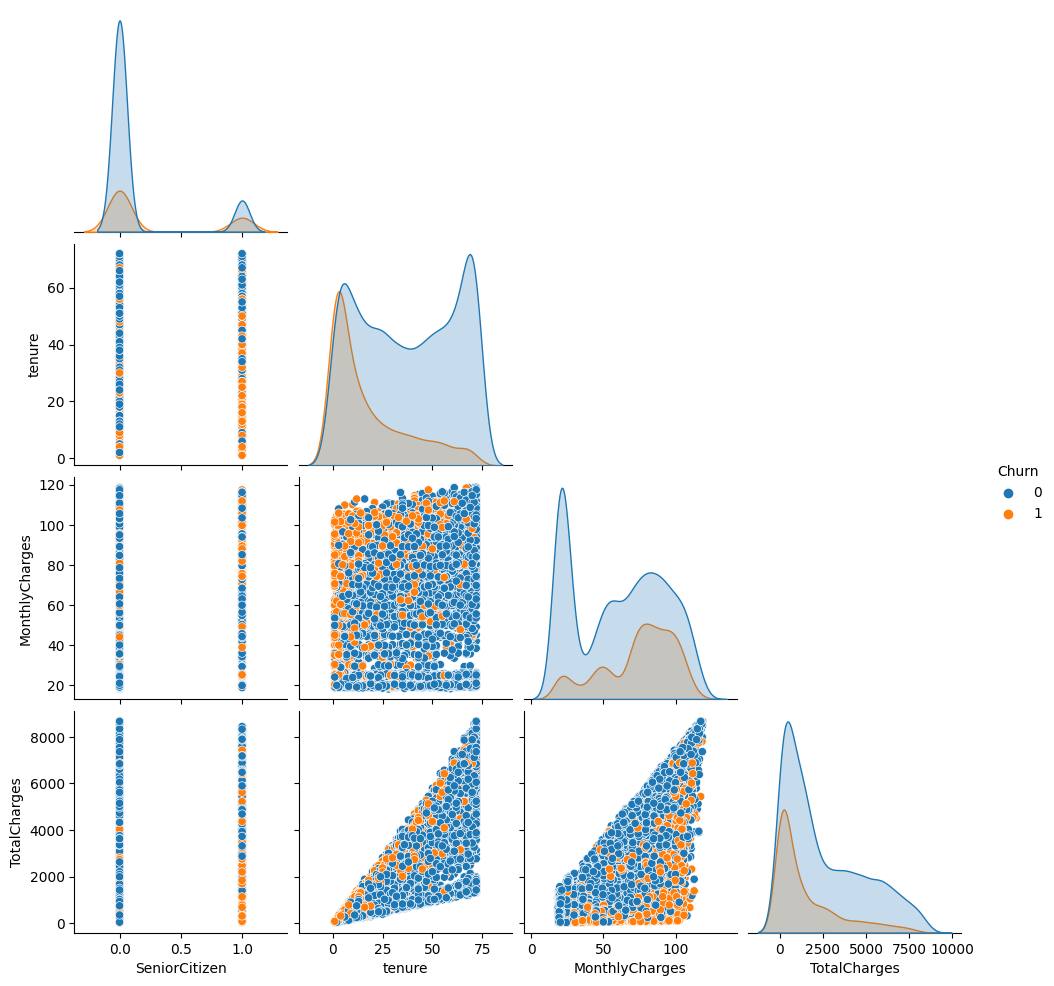

In [522]:
sns.pairplot(data=df,hue='Churn',corner=True)

Clients with shorter tenure have a higher chance of churn. The higher MonthlyCharges client has the more likely he is to Churn. Senior Citizens tend to Churn more often. We will examine it using correlation.

<Axes: >

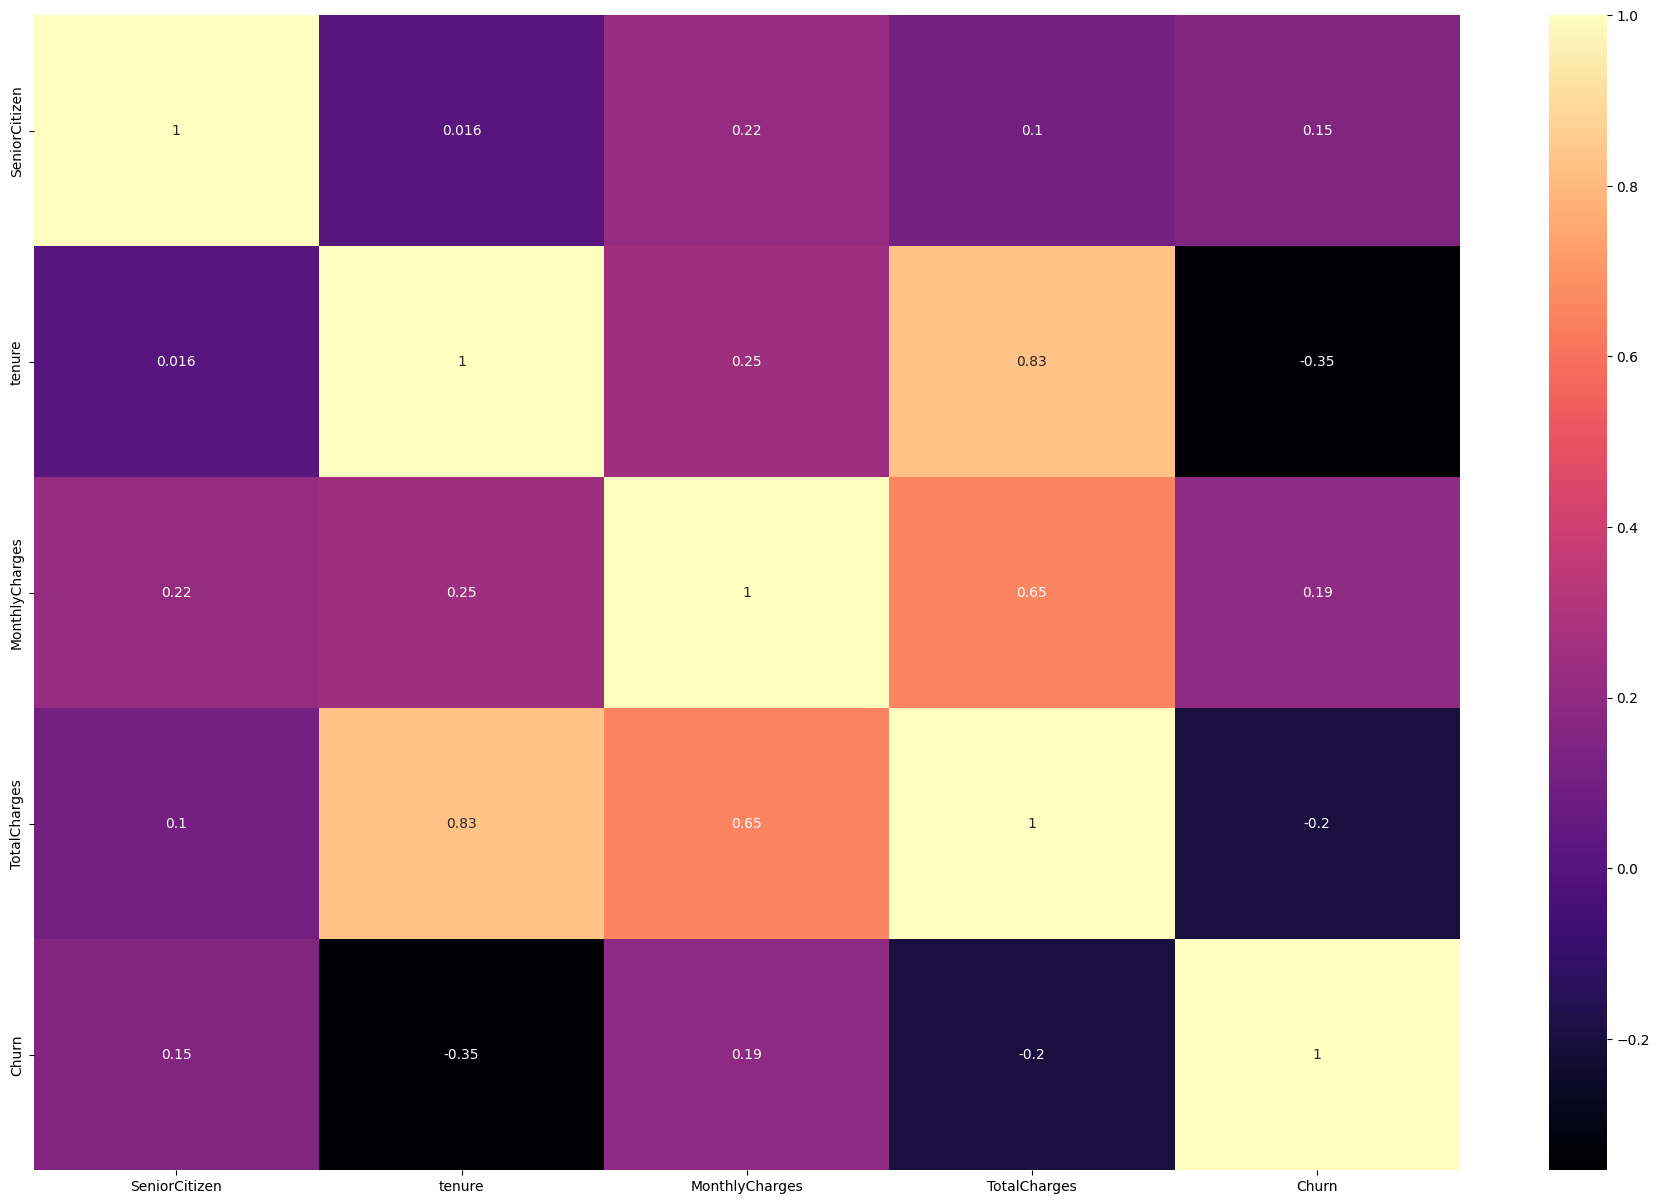

In [523]:
sns.heatmap(df[num_cols].corr(),annot=True,cmap="magma")

The analysis of the dataset reveals several noteworthy correlations between the numerical features and the target variable:

- We observe a modest level of correlation between the numerical features and the target variable.
- Senior citizen status and higher monthly charges exhibit a positive correlation with customer churn.
- Senior citizens are more prone to churn compared to younger customers.
- Customers with elevated monthly charges are also more inclined to churn in contrast to those with lower monthly charges.
- Long-term customers are less likely to churn compared to those with a shorter history with the company.
- A robust positive correlation exists between tenure and total charges.
- Notably, total charges demonstrate a negative correlation with churn.

## Bivariate analysis

In [524]:
# Adding merged column to analyze Churn depending on contract type and column
df['merged']=df['Churn'].astype(str)+' : '+df['Contract']

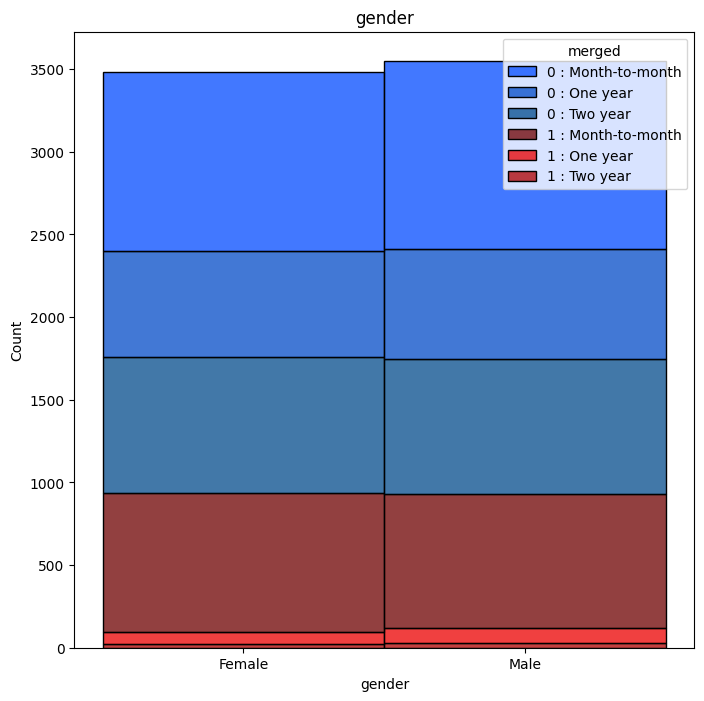

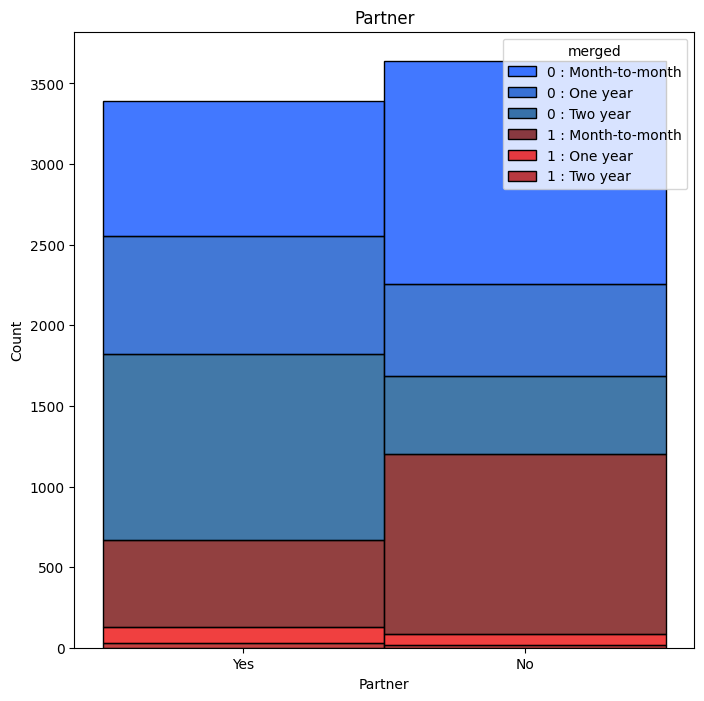

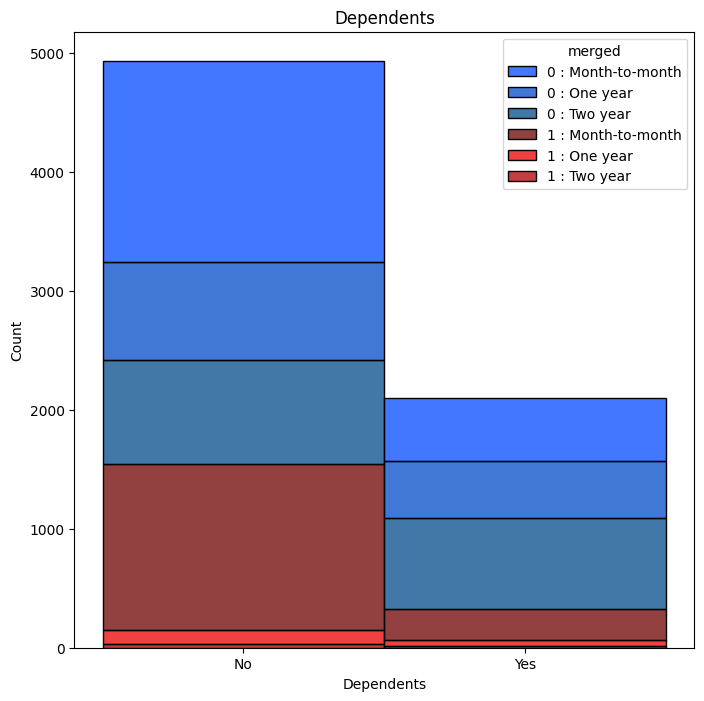

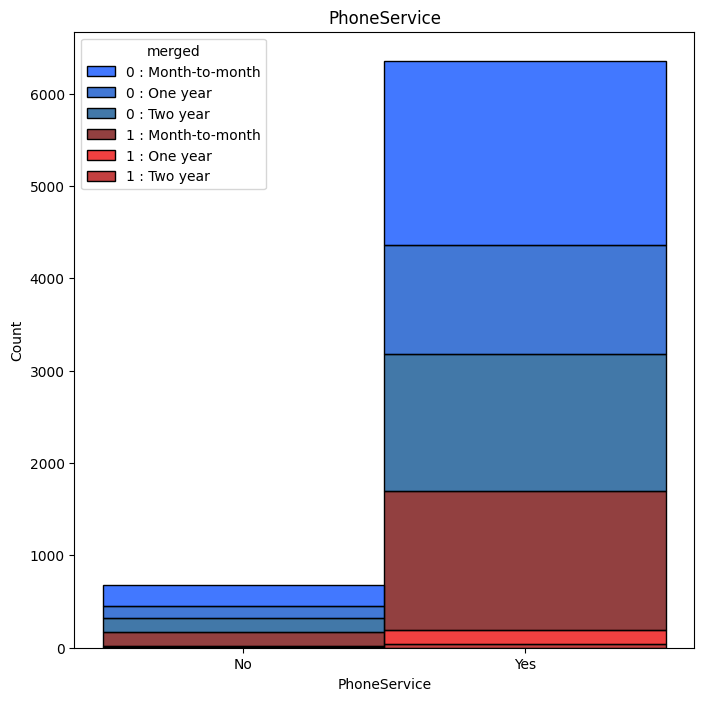

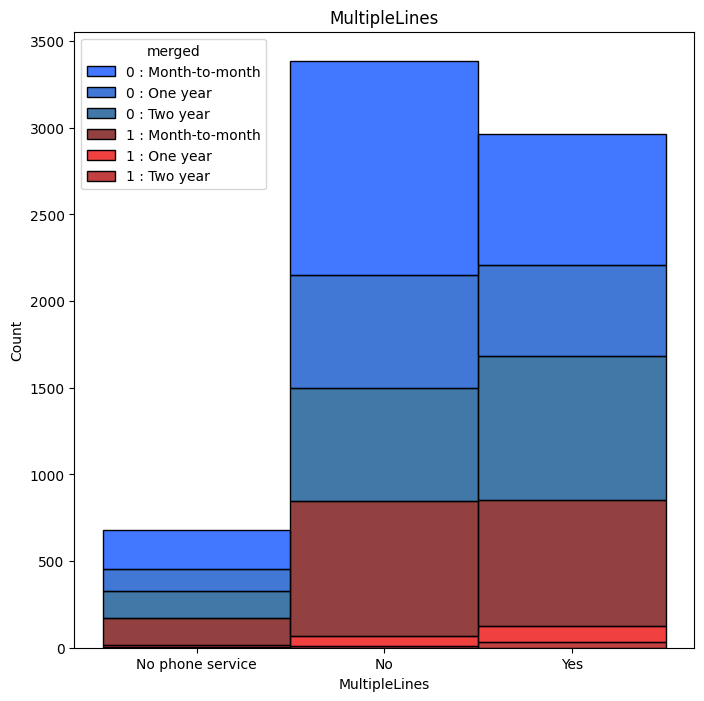

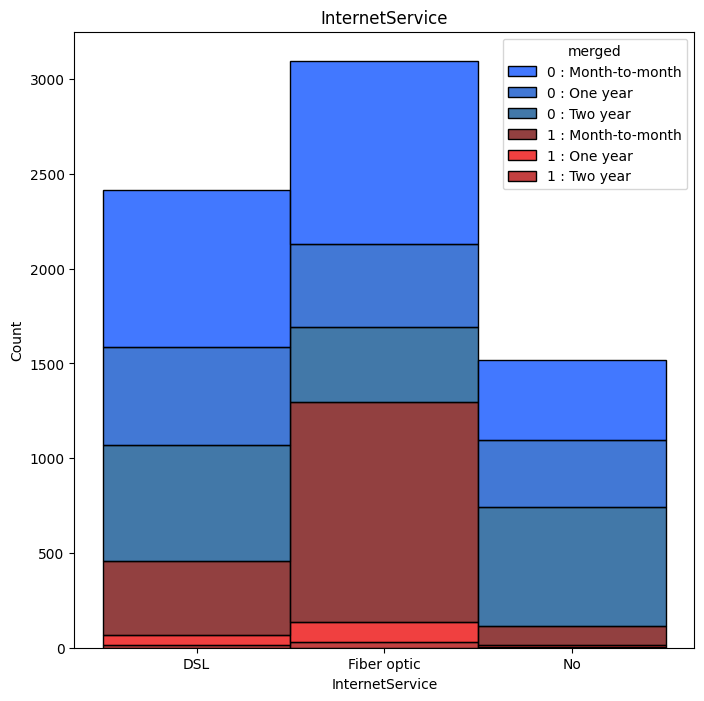

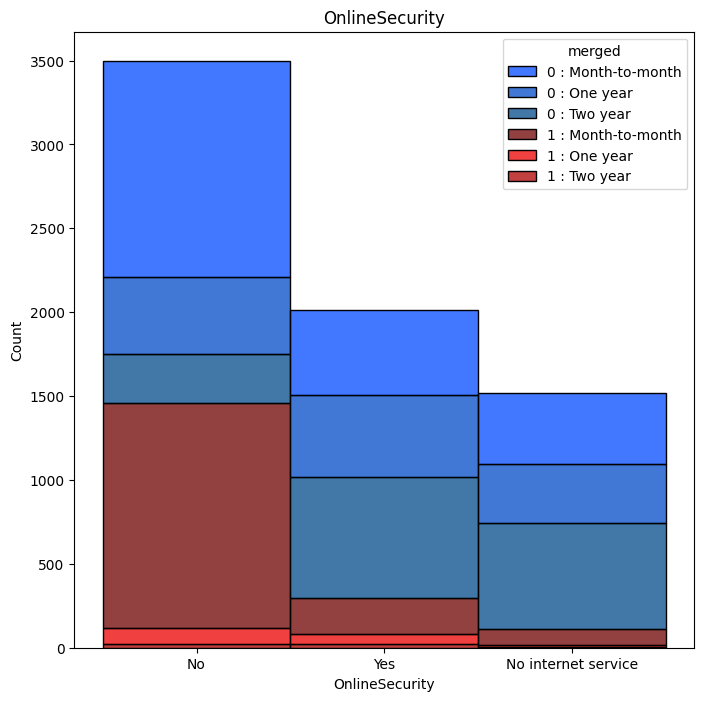

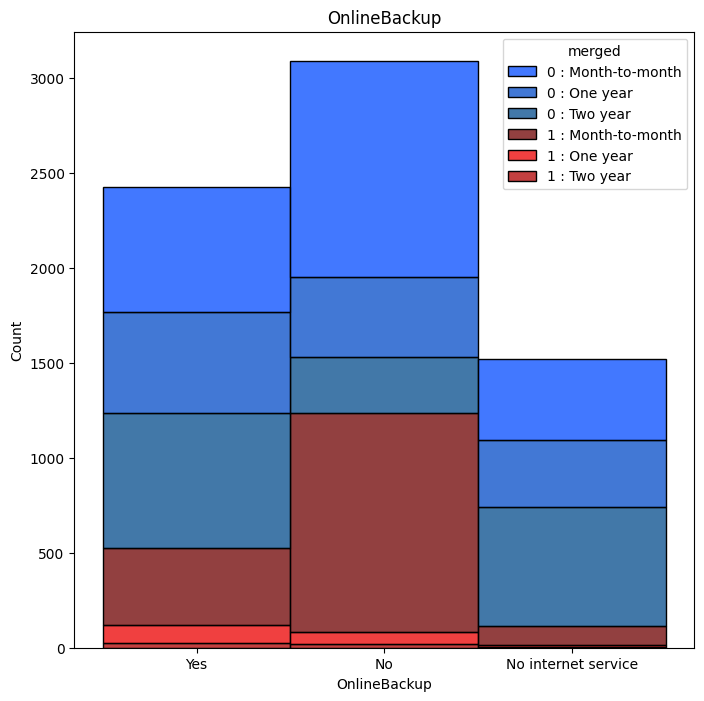

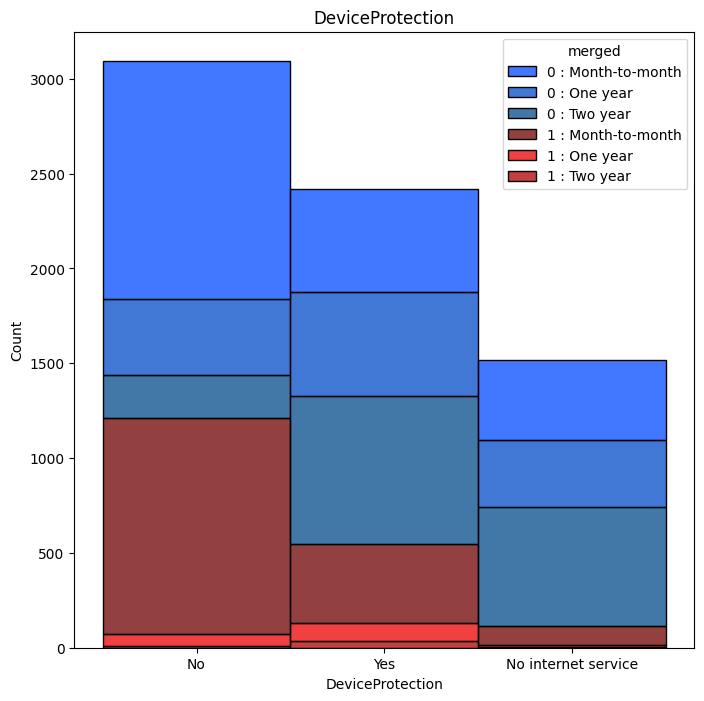

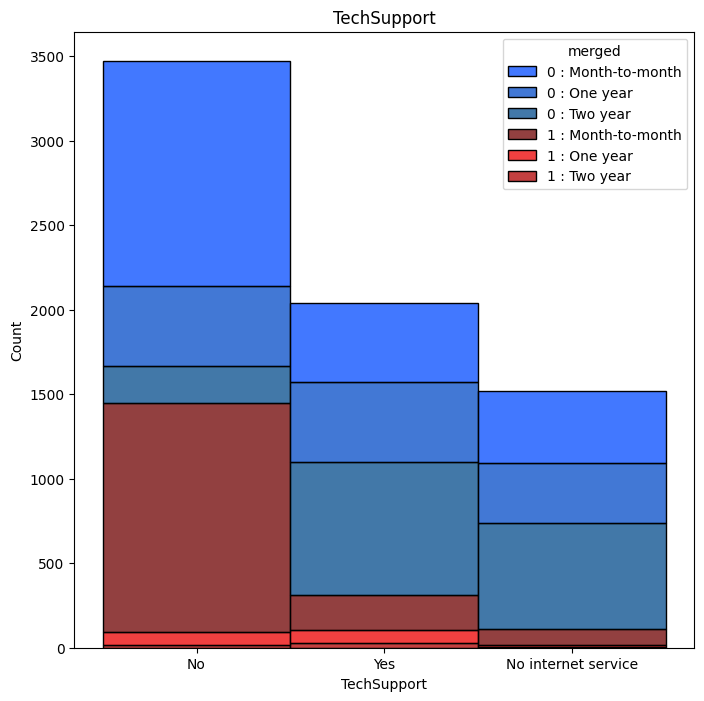

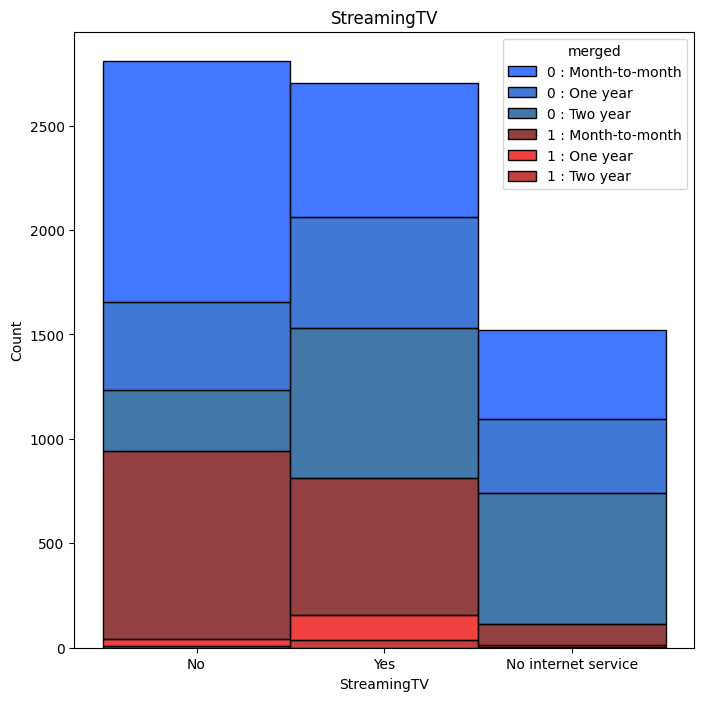

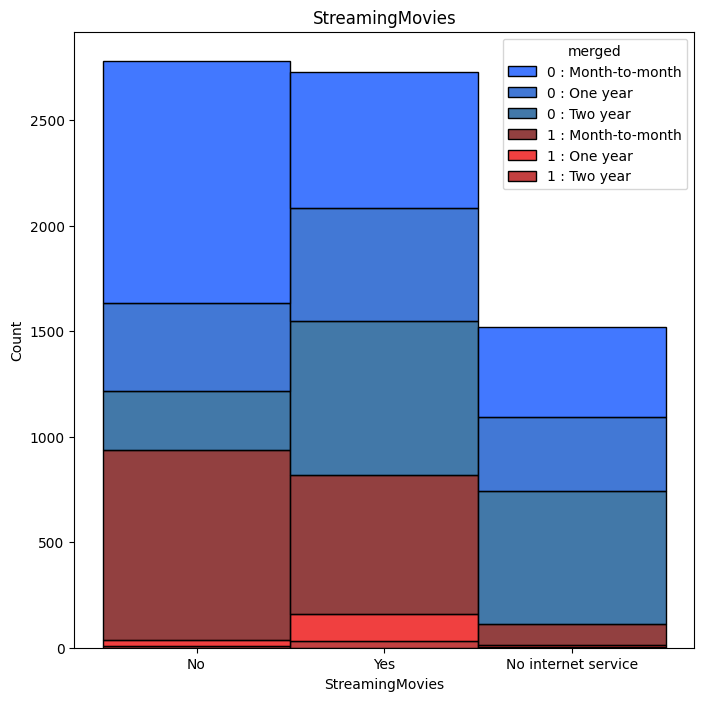

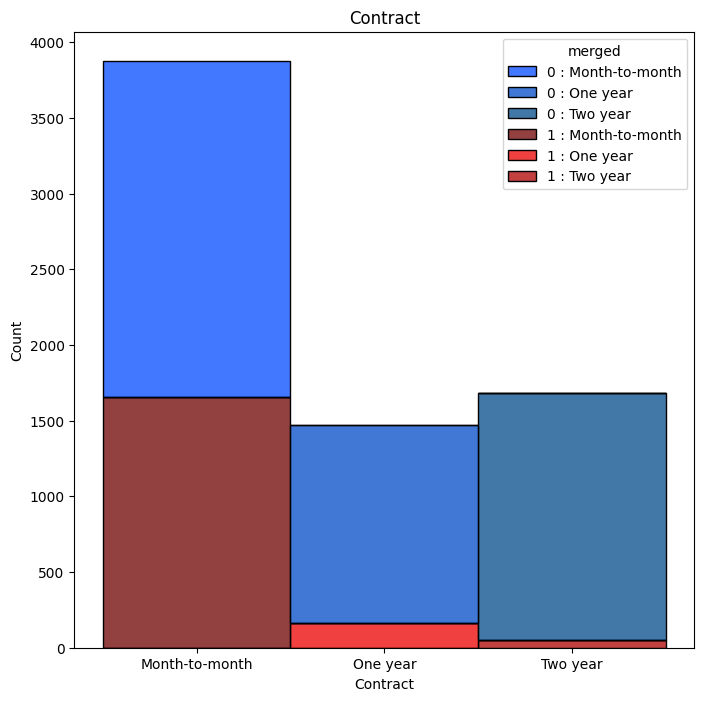

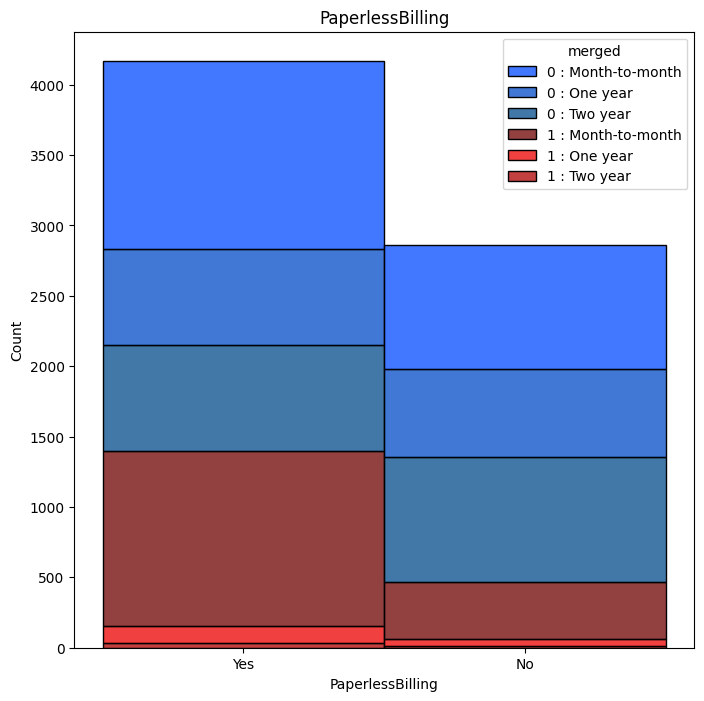

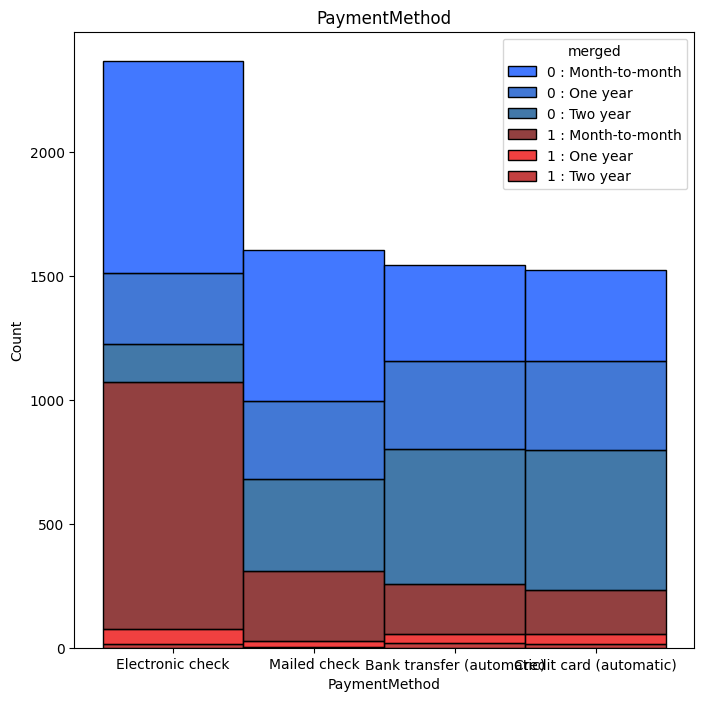

In [525]:
colors = {'0 : Month-to-month':'#024bff', '0 : One year':'#024bc7',
       '0 : Two year':'#024b8b', '1 : Month-to-month':'#6e0000', '1 : Two year':'#af0000', '1 : One year':'#eb0000'}
for i, col in enumerate(df[cat_cols].columns):
    plt.figure(figsize=(8, 8))
    sns.histplot(data=df, hue="merged", x=col, multiple="stack",palette=colors,hue_order=['0 : Month-to-month', '0 : One year',
       '0 : Two year','1 : Month-to-month', '1 : One year','1 : Two year'])
    plt.title(col)
    plt.show()

## Modeling


In [526]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,merged
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0 : Month-to-month
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0 : One year
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 : Month-to-month


In [527]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1973)

Data has been split to test and train subsets. Test set is 30% of the original dataset.

## Approach
We want to predict if client churned or not. We will use and compare multiple methods in order to achieve this goal. Based on this we will find a method that works best in our scenario.

In [529]:
#importing necessary libraries for model creation
import statsmodels.api as sm

from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier


First we will create linear Regression model using all available variables.

In [530]:
X_train_oh=pd.get_dummies(X_train.drop(columns=['merged']), dtype=float, drop_first=True)
X_test_oh=pd.get_dummies(X_test.drop(columns=['merged']), dtype=float, drop_first=True)

Creating dummy variables, also known as one-hot encoding, is necessary in linear regression when you have categorical variables because linear regression is designed to work with numerical data.

In [531]:
#fit regression model
model_lr = LogisticRegression()
model_lr.fit(X_train_oh,np.array(y_train).reshape(-1, 1),)

#view summary of model fit
y_prob = model_lr.predict_proba(X_test_oh)  # Returns probabilities for both classes (0 and 1)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Our models returns probability if client will churn, we want to test for best threshold above which we will assume client churns. In order to do that we will create function.

In [532]:
# Define a range of threshold values to test

def test_thresh(x):
    threshold_value=[]
    scores_acc=[]
    scores_f1=[]
    scores_rec=[]
    scores_prec=[]
    for i in np.linspace(0, 1, 51):
        threshold = i  # You can adjust the threshold as needed
        y_pred_fun = (x[:, 1] > threshold).astype(int)
        threshold_value.append(i)
        scores_acc.append(accuracy_score(y_test, y_pred_fun))
        scores_f1.append(f1_score(y_test, y_pred_fun))
        scores_rec.append((recall_score(y_test, y_pred_fun)))
        scores_prec.append((precision_score(y_test, y_pred_fun)))
        #scores_roc.append(roc_auc_score(y_test, y_prob))
    return pd.DataFrame({'threshold_value':threshold_value,'score_acc':scores_acc,'score_f1':scores_f1,'score_rec':scores_rec,'score_prec':scores_prec},index=threshold_value)

In [533]:
score_matrix=test_thresh(y_prob)
best_thresh=float(score_matrix.loc[score_matrix['score_acc']==score_matrix['score_acc'].max(),'threshold_value'])
print(f"We have highest accuracy with threshold set at {best_thresh*100} %. Meaning that if someone has a chance to churn higher than 52% we assume he will churn")

We have highest accuracy with threshold set at 52.0 %. Meaning that if someone has a chance to churn higher than 52% we assume he will churn


C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

Here we can see how our logistic regression model behaves for different threshold values. I decided to opt threshold that achieves max accuracy it will help us identify most of our clients correctly. In theory we could assume that everyone wants to Churn but that can not be justified in real world because we will target a lot of customers that will not churn in the end.
We achieve max accuracy with threshold set at 52%. 

In [534]:
# Apply a threshold to obtain binary predictions
y_pred = (y_prob[:,1].reshape(len(y_prob),1) > float(best_thresh)) # Predict class 1 if probability > threshold

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
print(f"""Accuracy is {round(accuracy*100,2)}% \n 
Recall is {round(recall*100,2)}% \n
Precision is {round(precision*100,2)}%""")

Accuracy is 80.43% 
 
Recall is 50.5% 

Precision is 71.84%


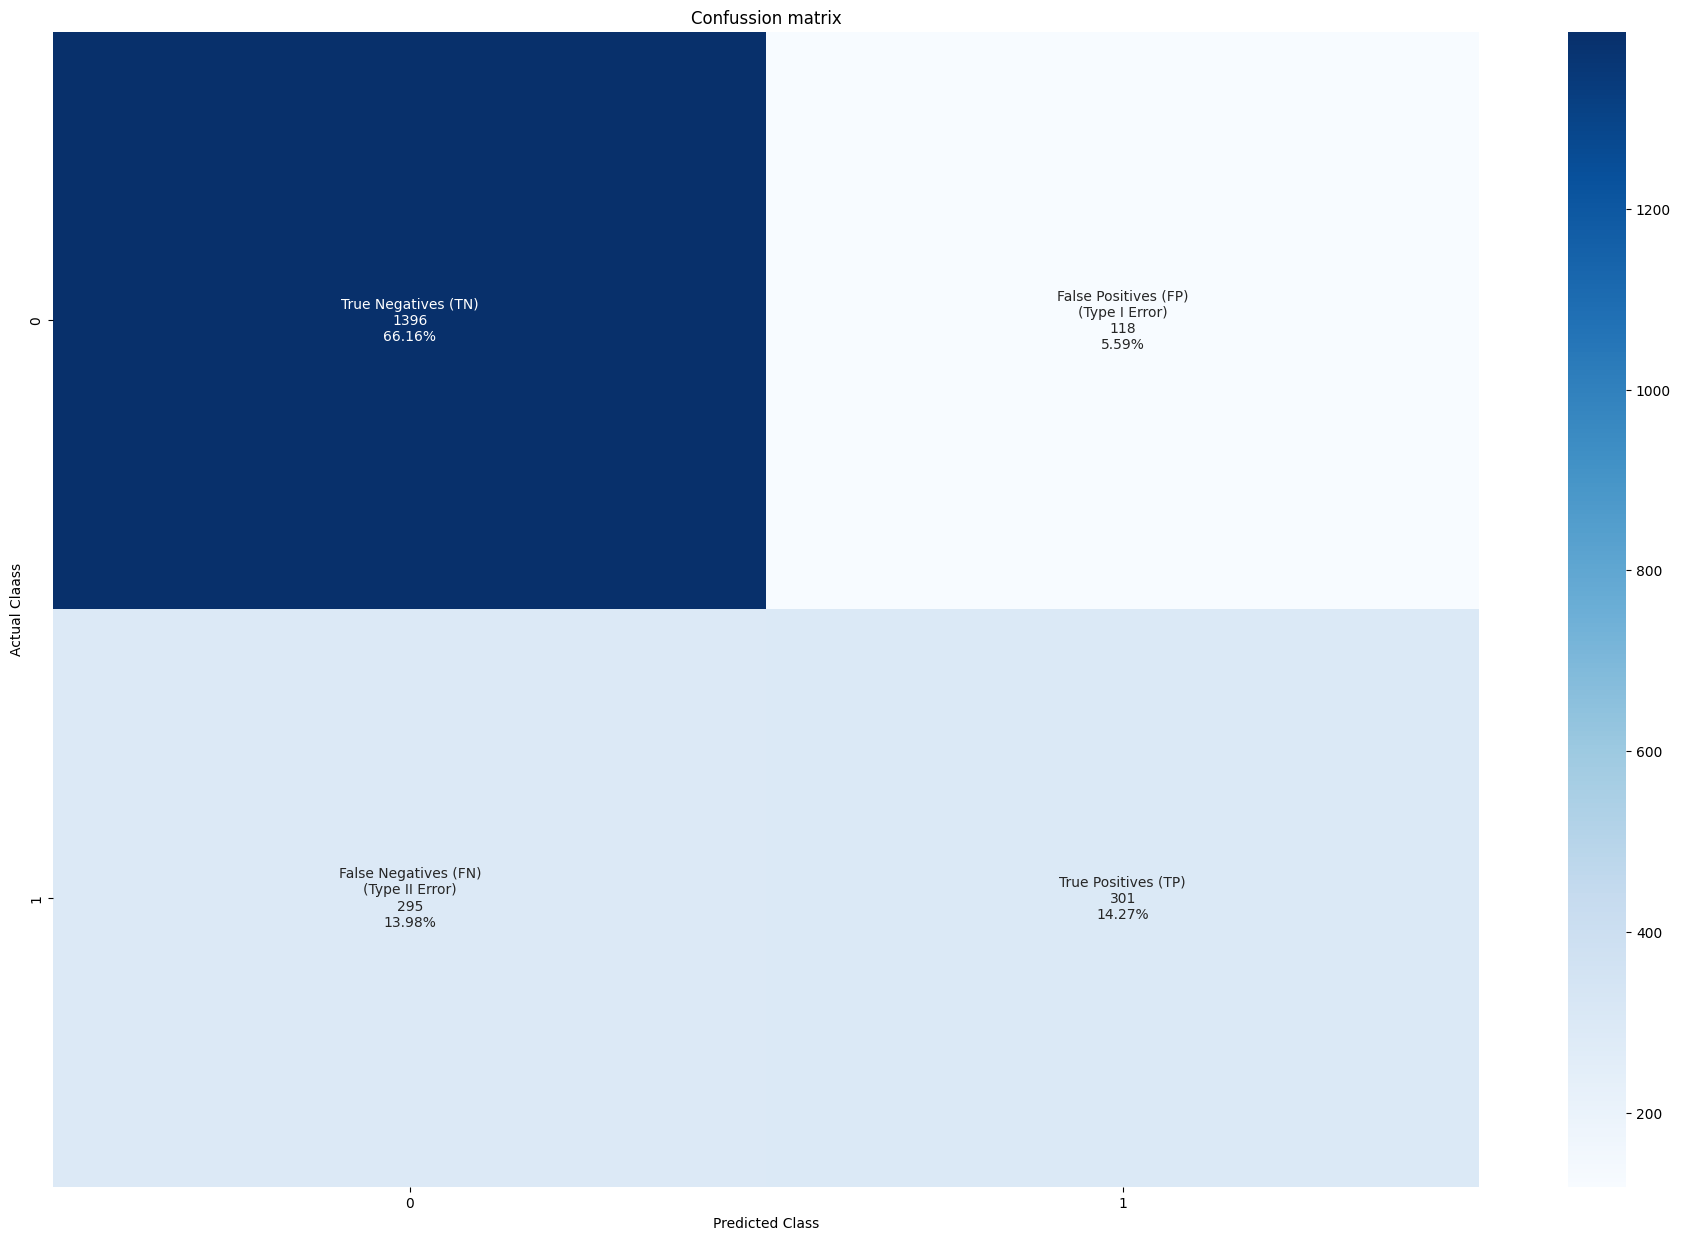

In [535]:
confusion = confusion_matrix(y_test, y_pred)
group_names = ["True Negatives (TN)", "False Positives (FP)\n(Type I Error)", "False Negatives (FN)\n(Type II Error)", "True Positives (TP)"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues")
ax.set(xlabel="Predicted Class", ylabel = "Actual Claass",title='Confussion matrix');

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

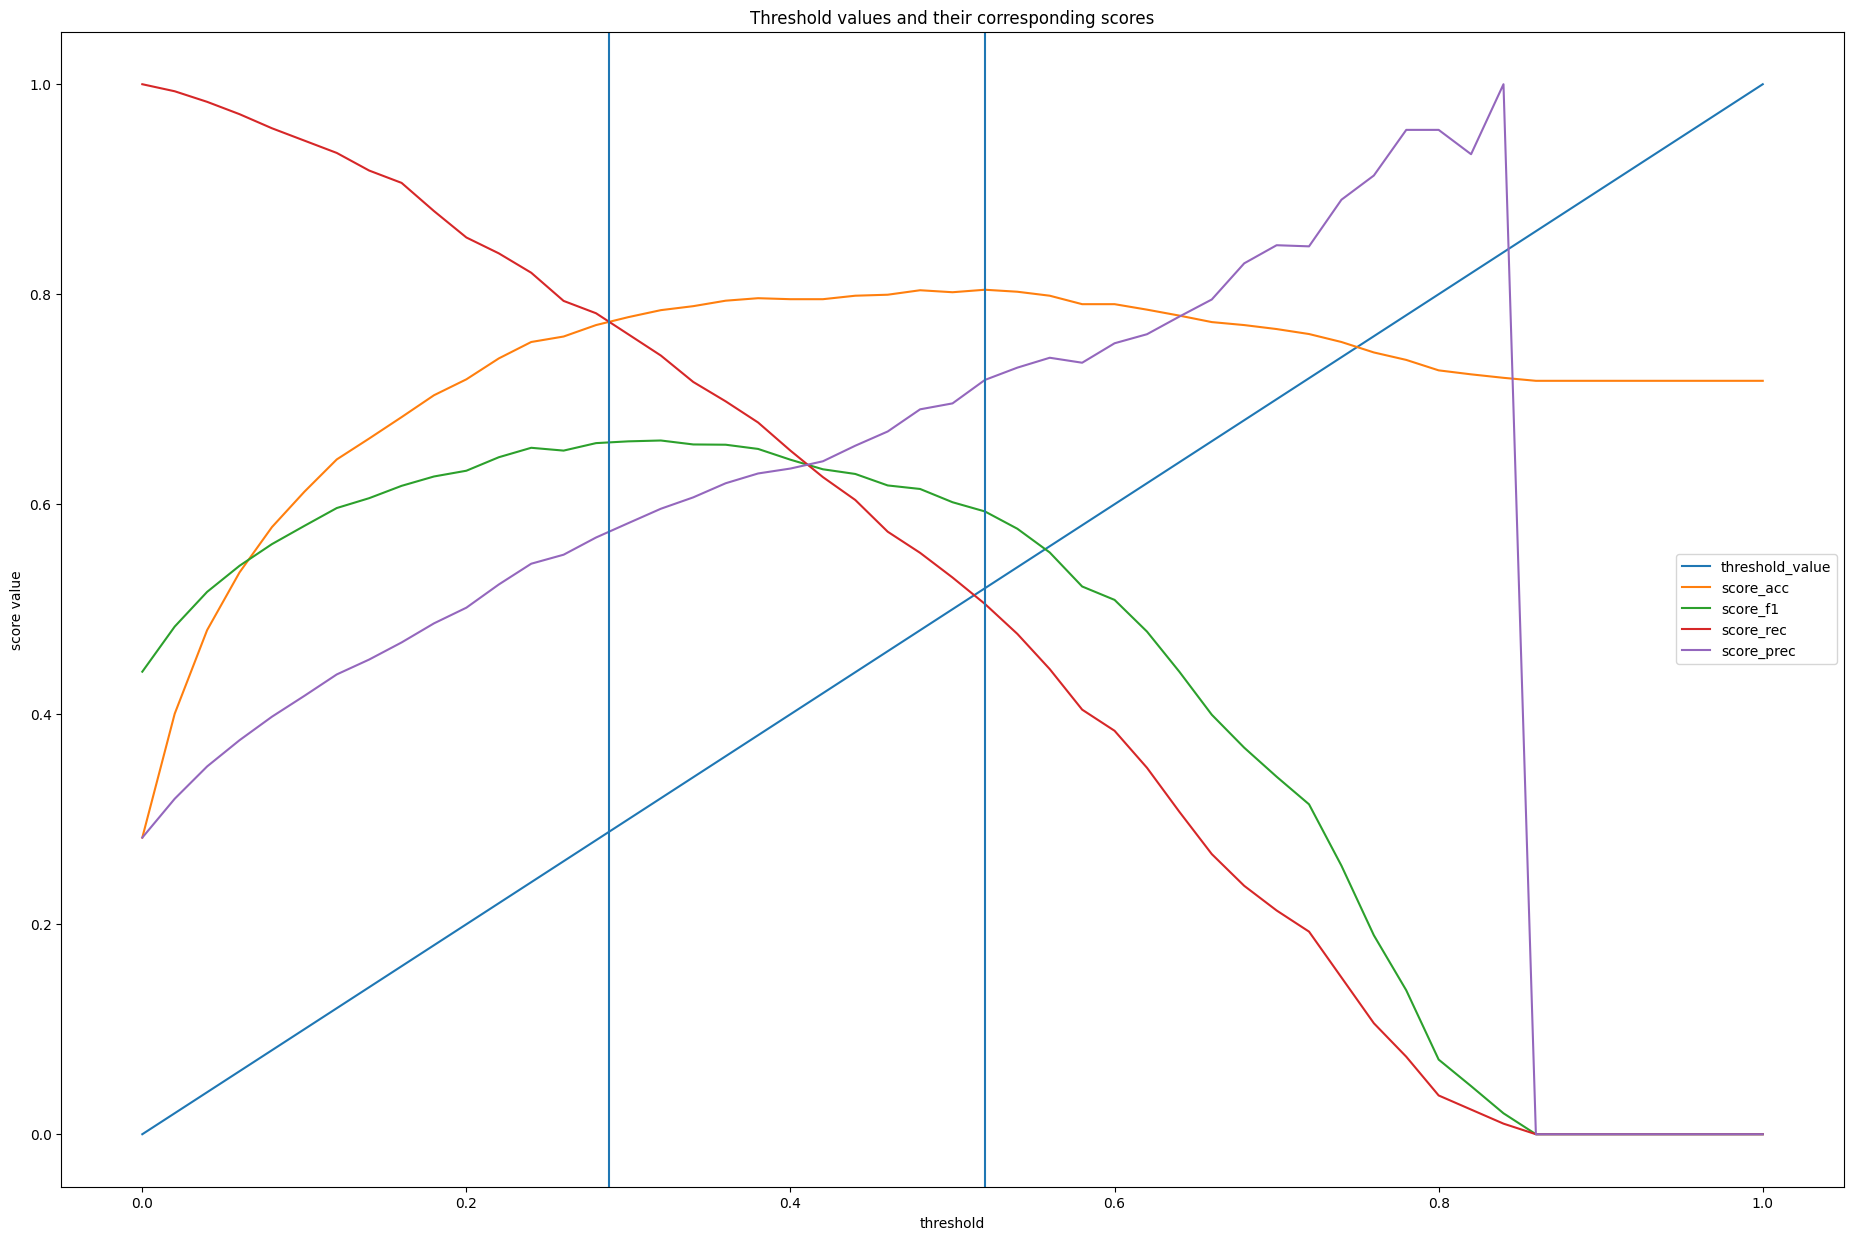

In [536]:
test_thresh(y_prob).plot(title='Threshold values and their corresponding scores',xlabel='threshold',ylabel='score value')
plt.axvline(0.52)
plt.axvline(0.288)

## Findings from first model
Our business goal is to identify as many customers that will churn as possible. In order to do that we choose threshold at 52% meaning that customer with a chance above 52% to churn is label as churn.
We choose this threshold because it achieves the best accuracy. 

- Accuracy is 80.43%: This means that the model correctly predicted approximately 80.43% of all cases, considering both customers who churned and those who did not. In other words, out of all predictions made by the model, about 80.43% were correct.

- Recall is 50.5%: The recall score of 50.5% indicates that the model successfully identified roughly 50.5% of the customers who actually churned. This metric measures the model's ability to capture churned customers out of all the customers who churned. In this case, the model identified about half of the churning customers.

- Precision is 71.84%: Precision at 71.84% tells us that when the model predicted a customer to churn, it was accurate approximately 71.84% of the time. In other words, out of all the predictions of churn made by the model, roughly 71.84% were correct.

FINDING: Looking at our model and its results for different thresholds i would propably suggest to choose smaller threshold at around 0.25-0.3 range. This will change models precision, it will drop a bit to around ~75%. Recall will be much higher at around 75% meaning that we will be able to identift 75% of customers that will Churn correctly meaning that we will be able to keep more of them, achievieng our business goal. Our threshold should not be only based on Precision. 

In [537]:
# Apply a threshold to obtain binary predictions
def acc_rec_prec(x,thresh=0.288):
    y_pred_final = (x[:,1].reshape(len(x),1) > thresh) # Predict class 1 if probability > threshold

    # Evaluate the model
    accuracy_final = accuracy_score(y_test, y_pred_final)
    recall_final=recall_score(y_test, y_pred_final)
    precision_final=precision_score(y_test, y_pred_final)
    print(f"""Accuracy is {round(accuracy_final*100,2)}% \n 
    Recall is {round(recall_final*100,2)}% \n
    Precision is {round(precision_final*100,2)}%""")

acc_rec_prec(y_prob)

Accuracy is 77.39% 
 
    Recall is 77.52% 

    Precision is 57.39%


By dropping threshold to 0.288 we were able to raise recall to 77.5% meaning that we are able to correctly identify 27 percentage points more of clients that want to churn. It is a huge difference with a minor drop in Accuracyy. Only downside to this approach is decrase in precision to 57.4% meaning that 43% of time we predict that customer will churn incorrectly. 

## Improving our base model
We should address class imbalance first!
### Introduction
Class imbalance is a common challenge in machine learning, particularly in binary classification tasks. In this report, we explore strategies to combat class imbalance in a dataset with 7,000 records, ensuring that our machine learning model can effectively learn from both minority and majority classes. Addressing class imbalance is crucial to prevent the model from being biased toward the majority class and to improve its predictive performance.
### Method and strategies
1. Modify the Decision Threshold and Use Different Evaluation Metrics - We already done that in our previous example maybe it will help there, we will see.
Adjust the classification threshold to increase sensitivity (lower threshold) or specificity (higher threshold) based on specific project objectives and requirements. Rely on metrics such as precision, recall, F1-score, ROC AUC, or PR AUC instead of accuracy to assess model performance, as they offer a more comprehensive view of performance in imbalanced datasets.
2. Ensemble Methods Consider using ensemble methods like Random Forest, Gradient Boosting, or Balanced Random Forest, which handle imbalanced datasets more effectively by giving weight to different classes. We will try that later, now we want to tweak only our base linear regression first.
3. Resampling Techniques, BINGO! Through simple resampling we should be able to achieve better results.
- Oversampling: Increase the number of Churn instances by duplicating or generating synthetic samples using methods like SMOTE or ADASYN.
- Undersampling: Reduce the number of No Churn instances by randomly removing samples. Be cautious to avoid loss of critical information.
- Combination of Oversampling and Undersampling: A balanced approach that combines both oversampling and undersampling techniques to address class imbalance.

In [552]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_oh, y_train)


In [553]:
#fit regression model
model_lr_resamp = LogisticRegression()
model_lr_resamp.fit(X_train_resampled,np.array(y_train_resampled).reshape(-1, 1),)

#view summary of model fit
y_prob_under = model_lr_under.predict_proba(X_test_oh)  # Returns probabilities for both classes (0 and 1)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

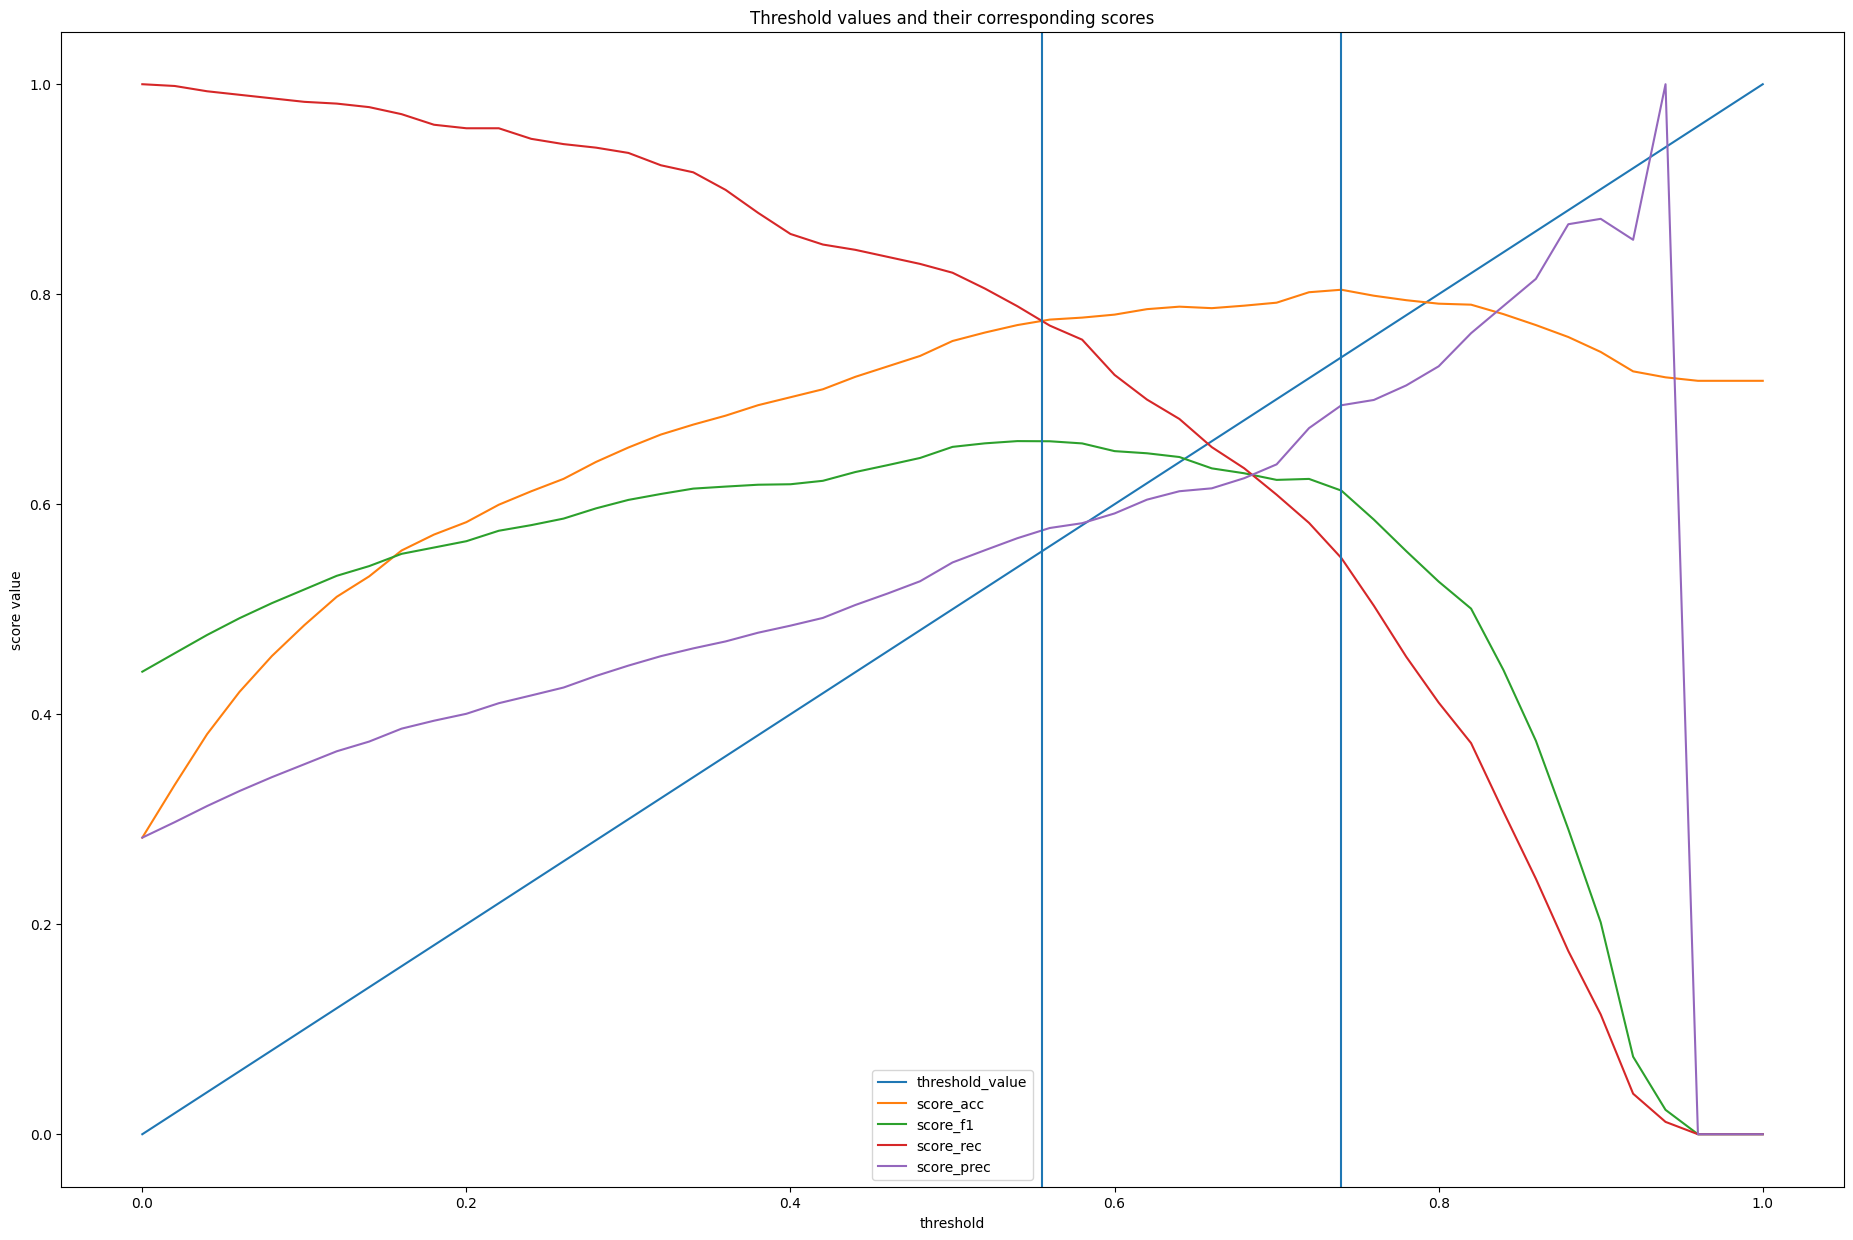

In [554]:
test_under=test_thresh(x=y_prob_under)
test_under.plot(title='Threshold values and their corresponding scores',xlabel='threshold',ylabel='score value')
plt.axvline(float(test_under.loc[test_under['score_acc']==test_under['score_acc'].max(),'threshold_value']))
plt.axvline(0.555)

In [556]:
acc_rec_prec(y_prob_under,thresh=0.555)

Accuracy is 77.44% 
 
    Recall is 77.52% 

    Precision is 57.46%


It turns out that our LR model is resistant to class imbalance, after resampling the model produced similiar results. Now we will try to crate a better model and use linear regression as benchmark.